Python for Data & Analytics<br>
Chapter 20, section 4

ATM Queueing Simulation

#### A) Arrival times with the exponential distribution

In [1]:
import numpy.random as npr
import matplotlib.pyplot as plt
import queue

In [2]:
# the seed allows for reproducibility of pseudo-random numbers
npr.seed(10)

In [3]:
# set an assumed arrival rate of 30 customers per hour
# then generate a random inter-arrival time (in hours)
arrivalRate = 30 # average number of customers arriving in an hour
npr.exponential(1/arrivalRate)

0.04918114818487275

In [4]:
# generate a random inter-arrival time, and convert to seconds
int(npr.exponential(1/arrivalRate) * 60 * 60)

2

In [5]:
# generate many inter-arrival times, in seconds
n = 10000
times = npr.exponential(1/arrivalRate, n) * 60 * 60

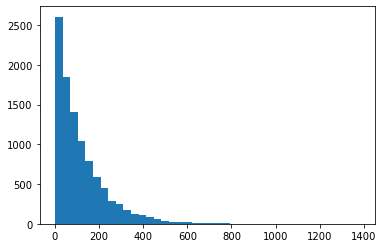

In [6]:
# visualize the inter-arrival distribution
plt.hist(times, bins=40)
plt.show()

In [7]:
# utility function to generate a random number of seconds
#  according to a rate using Poisson assumption
def genTime(rate):
    t = npr.exponential(1/rate)*60*60
    t = int(t)
    return max(t, 1)

In [8]:
# test the genTime() function
genTime(arrivalRate)

79

In [9]:
# function to generate a list of random arrival times, based on an arrival rate
def genArrivalTimes(rate, maxSeconds):
    iat0 = genTime(rate)
    if iat0 > maxSeconds: return []
    result = [iat0]
    iat = genTime(rate)
    while (result[-1]+iat) < maxSeconds:
        result.append(result[-1]+iat)
        iat = genTime(rate)
    return result

In [10]:
# generate a list of arrival times (arrivalRate previously set to 30)
maxSeconds = 3600 # 60 minutes
arrivalTimes = genArrivalTimes(arrivalRate, maxSeconds)

In [11]:
# display the arrival times
print(arrivalTimes)

[5, 44, 433, 557, 723, 751, 868, 927, 956, 1009, 1282, 1467, 1494, 1561, 1586, 1612, 1812, 1836, 1861, 1880, 2060, 2149, 2153, 2229, 2303, 2333, 2528, 2690, 2892, 3044, 3048, 3098, 3105, 3312, 3334, 3426]


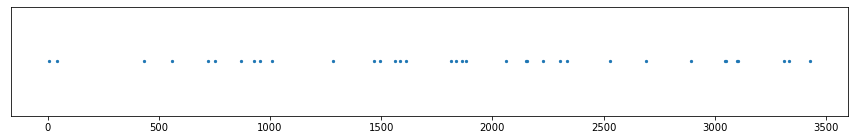

In [12]:
# visualize the arrival times
f = plt.figure() 
f.set_figwidth(15) 
f.set_figheight(2) 
plt.scatter(arrivalTimes, len(arrivalTimes)*[1], s=5)
plt.yticks([])
plt.show()

#### B) A Customer class

In [13]:
# a Customer keeps track of its times:
#   arrival, service length, service start, service end
class Customer:
    # create a Customer instance
    def __init__(self, arriveTime):
        self.arriveTime = arriveTime
        self.startTime = None
        self.serveLength = None
    # record a service event: start time and service time
    def serve(self, startTime, serveLength):
        self.startTime = startTime
        self.serveLength = serveLength
    # calculate when service ended
    def endTime(self):
        return self.startTime + self.serveLength
    # calculate waiting time to be served
    def waitTime(self):
        if self.startTime == None: return None
        return self.startTime - self.arriveTime

In [14]:
# test the Customer class
customer = Customer(20)
customer.serve(25, 10)
print('End time=', customer.endTime())
print('Wait seconds=', customer.waitTime())

End time= 35
Wait seconds= 5


#### C) Queueing Simulation

In [15]:
# set the parameters
serviceRate = 120    # average number of customers served per hour
arrivalRate = 60     # average number of customers arriving in an hour
totalTime = 8 * 60 * 60 # total time of simulation in seconds (8 hrs)
# Initialize other variables
qu = queue.Queue()   # as customers arrive, they are put into a Queue
currentCustomer = None # current customer being served (or None)
customersDone = []   # list of customers who have been served
n = 0                # number of arrivals
# Run the simulation
nextArrival = genTime(arrivalRate) # time of first arrival
for t in range(totalTime):         # simulate second-by-second
    # EVENT DONE: is the server finished with the current customer?
    if currentCustomer != None and currentCustomer.endTime() == t:
        #print("Service complete", t)
        customersDone.append(currentCustomer)
        currentCustomer = None
    # EVENT ARRIVE: is there an arrival at this time?
    if nextArrival == t:
        #print("Arrival", t)
        customer = Customer(t)
        qu.put(customer)
        nextArrival = t + genTime(arrivalRate)
        n += 1
    # EVENT NEXT: is  server available and is there someone waiting?
    if currentCustomer == None and not qu.empty():
        #print("Service starts", t)
        currentCustomer = qu.get()
        serviceTime = genTime(serviceRate)
        currentCustomer.serve(t, serviceTime)

In [16]:
# simulation summary counts
print('Number of arrivals:', n)
print('Number served:', len(customersDone))

Number of arrivals: 460
Number served: 456


In [17]:
# review some customer's arrival & start times, as well as their service & wait times 
nToDisplay = 10
print('  #  arrive   start service    wait')
for i in range(nToDisplay):
    customer = customersDone[i]
    print(f'{i+1:3d}'
          f' {customer.arriveTime:7,d} {customer.startTime:7,d}'
          f' {customer.serveLength:7,d} {customer.waitTime():7,d}')

  #  arrive   start service    wait
  1     157     157      29       0
  2     173     186       2      13
  3     291     291      54       0
  4     302     345       1      43
  5     452     452      26       0
  6     481     481       2       0
  7     546     546      13       0
  8     612     612       1       0
  9     691     691      76       0
 10     707     767      72      60


In [18]:
# collect wait times in a list
waitTimes = []
for customer in customersDone:
    if customer.waitTime() != None:
       waitTimes.append(customer.waitTime())

In [19]:
# report average and maximum wait times
avgWaitTime = sum(waitTimes) / len(waitTimes)
maxWaitTime = max(waitTimes)
print("average wait time:", round(avgWaitTime, 1), 'seconds')
print("maximum wait time:", maxWaitTime, 'seconds')

average wait time: 28.4 seconds
maximum wait time: 274 seconds


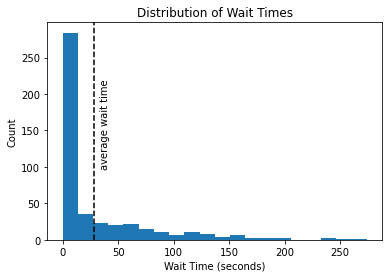

In [20]:
# visualize distribution of wait times
plt.hist(waitTimes, bins=20)
plt.axvline(x=avgWaitTime, linestyle='dashed', color='black')
plt.text(avgWaitTime+5,100,'average wait time',rotation=90)
plt.title('Distribution of Wait Times')
plt.xlabel('Wait Time (seconds)')
plt.ylabel('Count')
plt.show()

In [21]:
# calculate number of customers waiting more than 1 minute
threshold = 60
hiWaitCount = 0
for waitTime in waitTimes:
    if waitTime > threshold:
        hiWaitCount += 1

In [22]:
# report % waiting over threshold
hiWeightPct = hiWaitCount/len(waitTimes)*100
print('Customers waiting more than', threshold, 'seconds:', round(hiWeightPct), '%')

Customers waiting more than 60 seconds: 18 %


Code supplement for: Python for Data & Analytics, (c) 2024 Rose River Software, LLC